# Embedding functions

Using the appropriate model, anything can be embedded. For this exercise we're going to use embeddings to do semantic search over Rick and Morty quotes

### ChatGPT doesn't have parents or emotions

Vector search is useful for retrieving data that's not part of the model's training data.

For example, if we asked the following question to ChatGPT, we get some generic sounding answer wrapping around the core "she does not make any statements about causing her parents misery".

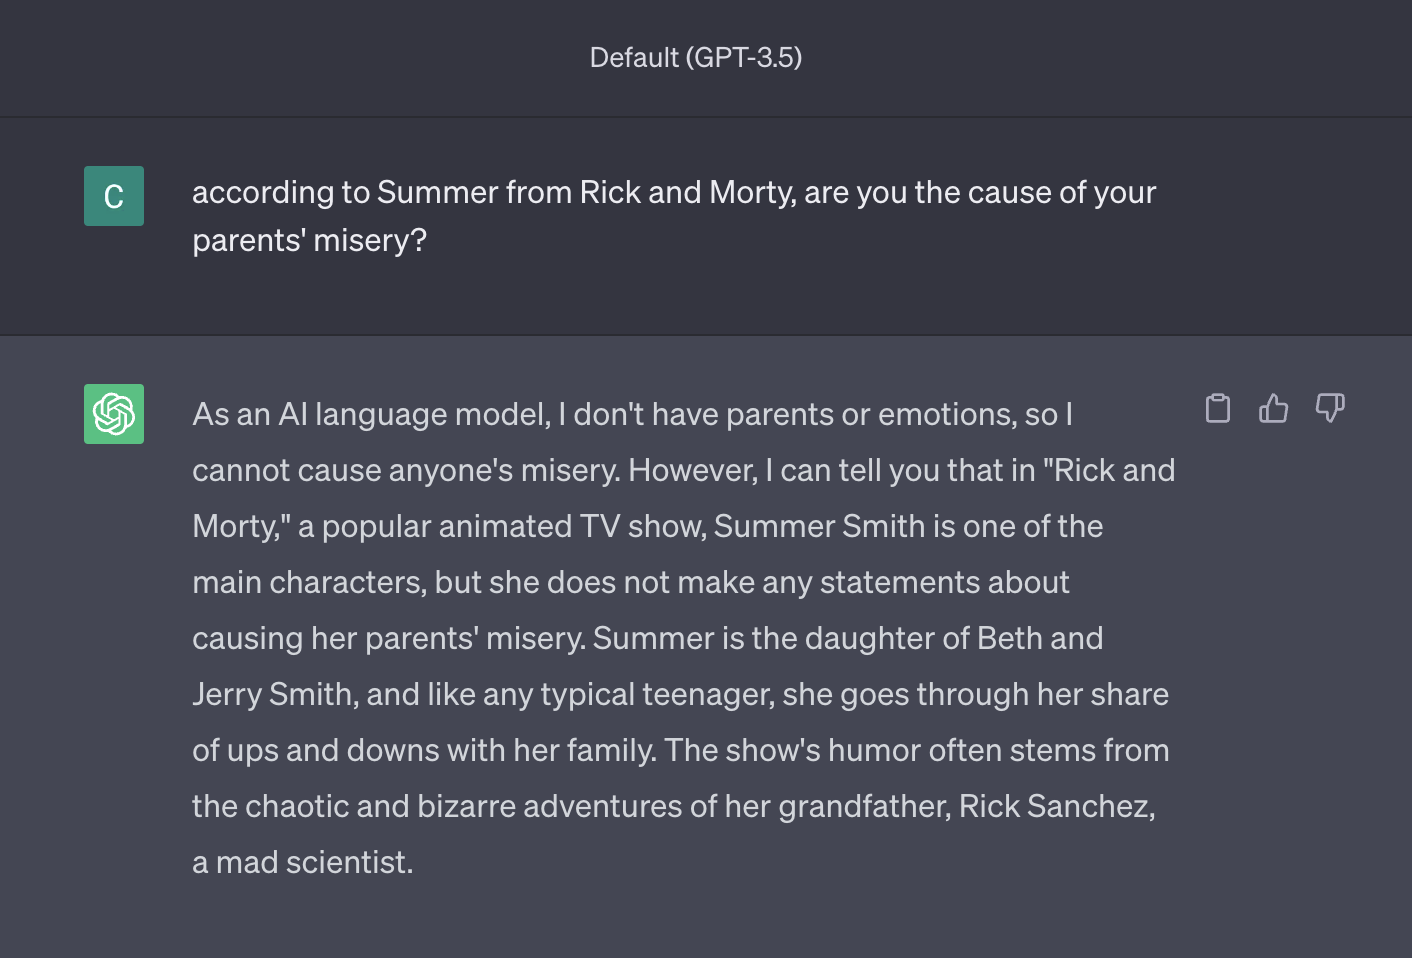

But what if searched through actual quotes from the show?

### [HuggingFace Sentence Transformers](https://huggingface.co/sentence-transformers) has been installed for you.

In [ ]:
# pip install -U --quiet sentence-transformers [This has been installed for you]

### Read data

Now let's read the quotes from the included text file (source: https://parade.com/tv/rick-and-morty-quotes). 

**SOLUTION** Here each quote lives on it's own line of text. So we just do `readlines` here. Remember to use the context manager to close resources. 

In [1]:
def read_quotes() -> list[str]:
    with open("rick_and_morty_quotes.txt", "r") as fh:
        return fh.readlines()

In [2]:
rick_and_morty_quotes = read_quotes()
rick_and_morty_quotes[:3]

["Losers look stuff up while the rest of us are carpin' all them diems.\n",
 "He's not a hot girl. He can't just bail on his life and set up shop in someone else's.\n",
 "When you are an a—hole, it doesn't matter how right you are. Nobody wants to give you the satisfaction.\n"]

Oops it seems like we have some extra newlines at the end of these quotes. Does that matter?
How do we prove it to ourselves?

**SOLUTION** turns out the answer is no. The reason is because the transformer library will strip the text of special characters.

In [3]:
import numpy as np
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

emb1, emb2 = model.encode([
 "Losers look stuff up while the rest of us are carpin' all them diems.\n",
 "Losers look stuff up while the rest of us are carpin' all them diems."
])
    
np.allclose(emb1, emb2)

True

### Write function to generate embeddings from text

Write a function that turns text into embeddings using Sentence Transformers.

**HINT**
1. Choose a [pre-trained model](https://www.sbert.net/docs/pretrained_models.html), you don't need to create your own
2. See the API documentation and examples for Sentence Transformers to see how to encode text

**SOLUTION**
Sentence Transformers make this pretty easy. First we load the model using the model name you chose.
Then we call the `model.encode()` function to generate the embeddings. If you pass in a single string,
then a 1D numpy array is returned. Otherwise a 2D array is returned.

In [4]:
import numpy as np
from sentence_transformers import SentenceTransformer
from typing import Union

MODEL_NAME = 'paraphrase-MiniLM-L6-v2'

def generate_embeddings(input_data: Union[str, list[str]]) -> np.ndarray:    
    model = SentenceTransformer(MODEL_NAME)
    embeddings = model.encode(input_data)
    return embeddings

In [5]:
embeddings = generate_embeddings(rick_and_morty_quotes)

In [6]:
#Print the embeddings
for sentence, embedding in zip(rick_and_morty_quotes[:3], embeddings[:3]):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: Losers look stuff up while the rest of us are carpin' all them diems.

Embedding: [ 0.6188345   0.06881799  0.44374305 -0.45357847  0.30271497 -0.10784142
  0.4952488  -0.12448785  0.05482465 -0.04262822  0.04789169 -0.31940377
  0.18216974 -0.27199626 -0.14199588 -0.56009746 -0.35566285 -0.44555157
 -0.03909524  0.42247924 -0.4604969   0.26436502  0.16821663  0.34295756
  0.20552608  0.20994833 -0.07352602 -0.0243092  -0.07486243  0.41356117
 -0.09713856 -0.02470837  0.02246359  0.10461547  0.25205338 -0.05957111
  0.02156227  0.24379666  0.20664053 -0.40555897 -0.18285899  0.13926435
 -0.29004836  0.14936377 -0.17484201 -0.22140746 -0.01152995 -0.1715579
  0.2581103   0.01463477 -0.05509421  0.02583265  0.01430671 -0.13821091
  0.16159977 -0.56482404  0.4062962   0.08129338  0.18729608 -0.06932873
 -0.17729421 -0.1006496   0.3024407  -0.2205626  -0.2050517   0.13730268
  0.32069105  0.22979245 -0.22806767  0.37576777 -0.17270264 -0.17178848
  0.16163573  0.5295059  -0.19358

https://www.sbert.net/docs/pretrained_models.html


How many dimensions is each embedding?

In [7]:
len(embeddings[0])

384

Are the embeddings normalized already?

**SOLUTION** No they're not. We may want to add a step in the embedding function to normalize all vectors. OR we use cosine instead of Euclidean distance

In [8]:
np.linalg.norm(embeddings, axis=1)

array([5.5780635, 4.8029375, 4.740227 , 5.141901 , 7.0889506, 4.5193715,
       4.1849637, 5.134199 , 4.96831  , 5.2417045, 5.5314946, 4.3252525,
       6.9031262, 5.592641 , 5.2046595, 5.814751 , 6.899495 , 5.7716303,
       6.3855267, 5.230854 , 6.5764093, 5.3486414, 6.0708685, 7.759795 ,
       4.240743 , 4.5965443, 5.9753222, 4.7049956, 5.027794 , 7.618719 ,
       5.839973 , 5.6741776, 5.225594 , 6.63086  , 7.2901545, 5.076945 ,
       7.415248 , 5.5012593, 4.7184825, 5.834399 , 4.63456  , 5.4468746,
       5.329064 , 4.7717104, 5.175283 , 5.1571107, 6.2419677, 5.877234 ,
       4.933059 , 7.883933 , 4.9240727, 6.0574803, 4.257354 , 5.084045 ,
       5.6248083, 4.061501 , 5.489659 , 4.0482764], dtype=float32)

### Let's put it all together

First let's encode the question

In [9]:
query_text = "Are you the cause of your parents' misery?"
query_embedding = model.encode(query_text)

Now we can reuse the find_nearest_neighbors function we wrote for exercise 1.

However, that only returns the vectors, whereas we also want the quotes. So please rewrite the find_nearest_neighbors function to return the *indices* of the nearest neighbors.

In [10]:
import numpy as np

def euclidean_distance(v1: np.ndarray, v2: np.ndarray) -> float:
    """
    Compute the Euclidean distance between two vectors.

    Parameters
    ----------
    v1 : np.ndarray
        First vector.
    v2 : np.ndarray
        Second vector.

    Returns
    -------
    float
        Euclidean distance between `v1` and `v2`.
    """
    dist = v1 - v2
    return np.linalg.norm(dist, axis=len(dist.shape)-1)


def find_nearest_neighbors(query: np.ndarray,
                           vectors: np.ndarray,
                           k: int = 1) -> np.ndarray:
    """
    Find k-nearest neighbors of a query vector.

    Parameters
    ----------
    query : np.ndarray
        Query vector.
    vectors : np.ndarray
        Vectors to search.
    k : int, optional
        Number of nearest neighbors to return, by default 1.

    Returns
    -------
    np.ndarray
        The `k` nearest neighbors of `query` in `vectors`.
    """
    distances = euclidean_distance(query, vectors)
    return np.argsort(distances)[:k]

In [11]:
indices = find_nearest_neighbors(query_embedding, embeddings, k=3)

In [12]:
for i in indices:
    print(rick_and_morty_quotes[i])

You're not the cause of your parents' misery. You're just a symptom of it.

Having a family doesn't mean that you stop being an individual. You know the best thing you can do for the people that depend on you? Be honest with them, even if it means setting them free.

B—h, my generation gets traumatized for breakfast.



#### Asking the question again

Now let's use the retrieved quotes and ask ChatGPT to answer the question based on the quotes in addition to its own data

In [13]:
"""
Answer the question based on the context.

Question: Are you the cause of your parents' misery?

Context:

You're not the cause of your parents' misery. You're just a symptom of it.

Having a family doesn't mean that you stop being an individual. You know the best thing you can do for the people that depend on you? Be honest with them, even if it means setting them free.

B—h, my generation gets traumatized for breakfast.
"""

"\nAnswer the question based on the context.\n\nQuestion: Are you the cause of your parents' misery?\n\nContext:\n\nYou're not the cause of your parents' misery. You're just a symptom of it.\n\nHaving a family doesn't mean that you stop being an individual. You know the best thing you can do for the people that depend on you? Be honest with them, even if it means setting them free.\n\nB—h, my generation gets traumatized for breakfast.\n"

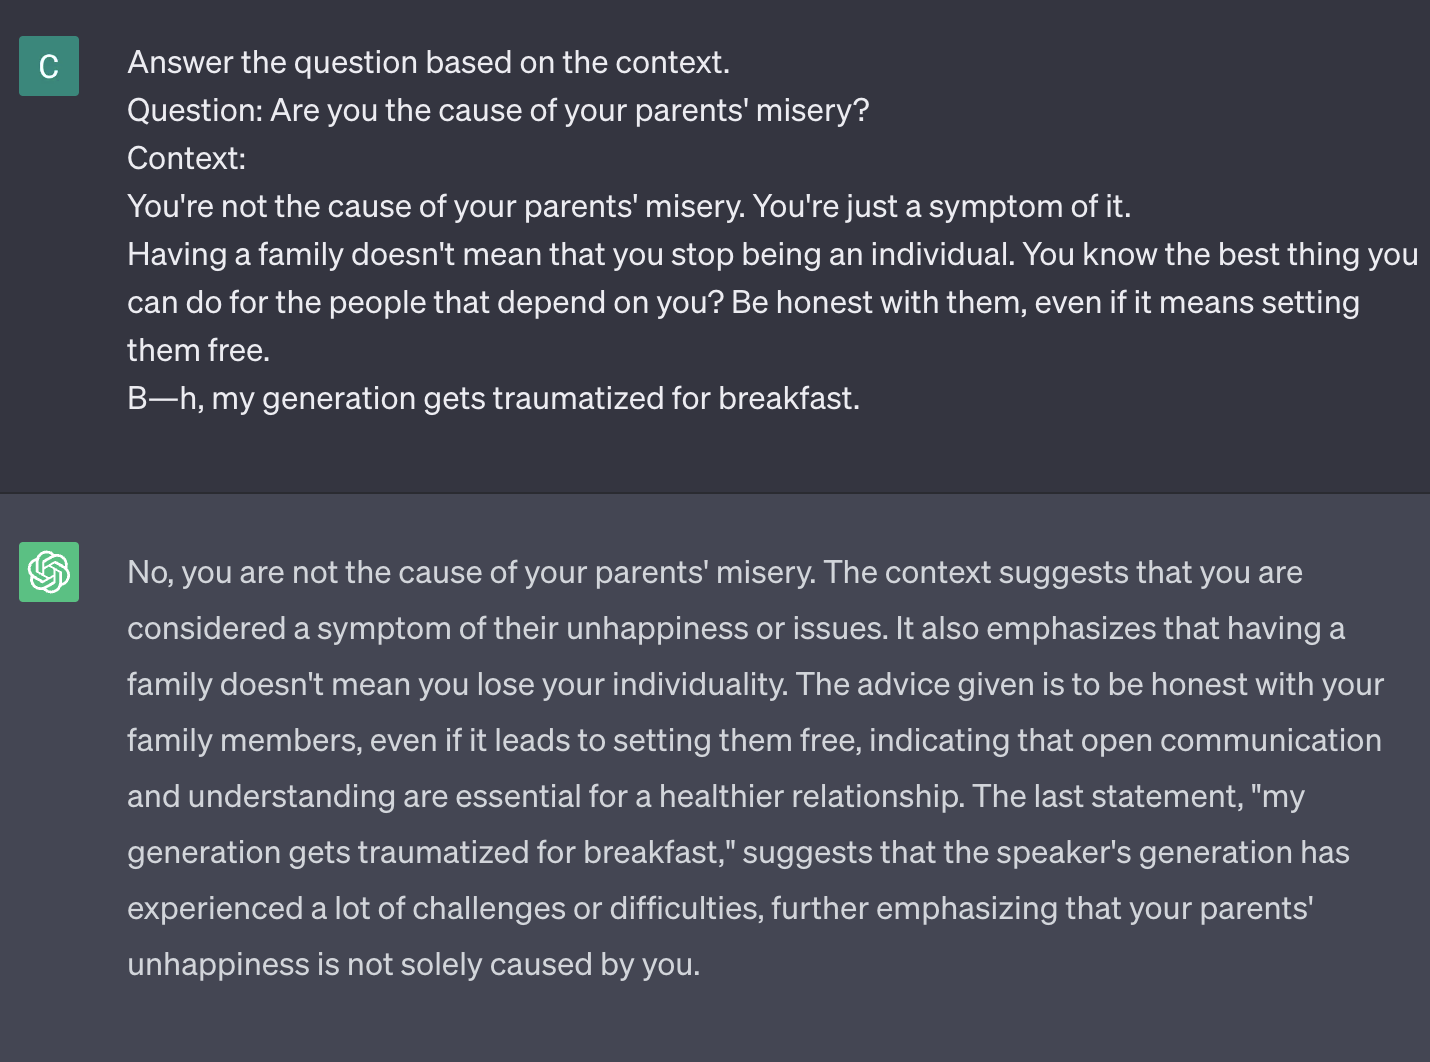